## DM-15224: Investigate low association rate in HiTS2015 CI dataset

While testing ap_verify_ci_hits2015, a set of six overlapping exposures across three epochs (visits), for DM-15142, Krzysztof got the following source matching statistics:

* 1600 DiaObjects with 1 DiaSource
* 82 DiaObjects with 2 DiaSources
* 0 DiaObjects with 3 DiaSources

The issue appears whether he runs ap_pipe all at once or in order of increasing visit ID, so it does not appear to be a concurrency bug in the database. On the other hand, the dataset footprint is known to include "messy" chips, so it's possible that many of the DIASources are transient artifacts rather than real sources. We began by pair-investigating the properties of the images and DIAObjects to figure out what is happening.

We found that part of the problem is that CCDs 58 and 62 do not overlap with the other images (because Krzysztof was comparing a East-is-left focal plane map to an East-is-right image of the HiTS 2015 dataset... whoops, that comparison image was my fault!). Looking at only the two visits with CCDs 5 and 10 in a slightly different reduction, we see:

* ~913 DIAObjects with 1 DIASource
* ~79 DIAObjects with 2 DIASources

I suspect the ~10% repeat DIASources despite the ~100% overlap is because most of the sources are image differencing artifacts; we will make plots of number of sources on the sky for each individual visit to test this hypothesis.

With the dataset amended as described in the comments to DM-15142 (switching 2 of the originally selected visits to CCDs 56 and 60 instead of 58 and 62), the statistics are:
* 1066 DiaObjects with 1 DiaSources
* 91 DiaObjects with 2 DiaSources
* 25 DiaObjects with 3 DiaSources

This is much more reasonable, but plots are still warranted. Enter **this notebook**.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import sqlite3
from astropy.time import Time

from lsst.daf.base import DateTime
import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist
import lsst.geom

repo = '/project/mrawls/hits2015/rerun/slurm6'

In [2]:
butler = dafPersist.Butler(repo)

In [3]:
sqliteFile = 'association.db'
connection = sqlite3.connect(os.path.join(repo, sqliteFile))

tables = {'obj': 'dia_objects', 'src': 'dia_sources', 'ccd': 'CcdVisit'}

objTable = pd.read_sql_query('select * from {0};'.format(tables['obj']), connection)
srcTable = pd.read_sql_query('select * from {0};'.format(tables['src']), connection)
ccdTable = pd.read_sql_query('select * from {0};'.format(tables['ccd']), connection)

connection.close()

In [4]:
# Look at the columns in each table
print(objTable.columns)
print(srcTable.columns)
print(ccdTable.columns)

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'pixelId', 'nDiaSources',
       'psFluxMean_u', 'psFluxMeanErr_u', 'psFluxSigma_u', 'psFluxMean_g',
       'psFluxMeanErr_g', 'psFluxSigma_g', 'psFluxMean_r', 'psFluxMeanErr_r',
       'psFluxSigma_r', 'psFluxMean_i', 'psFluxMeanErr_i', 'psFluxSigma_i',
       'psFluxMean_z', 'psFluxMeanErr_z', 'psFluxSigma_z', 'psFluxMean_y',
       'psFluxMeanErr_y', 'psFluxSigma_y', 'psFluxMean_VR', 'psFluxMeanErr_VR',
       'psFluxSigma_VR', 'psFluxMean_N964', 'psFluxMeanErr_N964',
       'psFluxSigma_N964'],
      dtype='object')
Index(['id', 'coord_ra', 'coord_dec', 'parent', 'diaObjectId', 'ccdVisitId',
       'psFlux', 'psFluxErr', 'filterName', 'filterId', 'flags', 'pixelId'],
      dtype='object')
Index(['ccdVisitId', 'ccdNum', 'filterName', 'filterId', 'ra', 'decl',
       'expTime', 'expMidptMJD', 'fluxZeroPoint', 'fluxZeroPointErr'],
      dtype='object')


In [5]:
# Make two "subsets" of sources on the sky, with a declination cut
dec_set1 = (objTable['coord_dec'] > -2)
dec_set2 = ~dec_set1

# Save the number of sources for each object in each subset
src_count1 = objTable.loc[dec_set1, 'nDiaSources']
src_count2 = objTable.loc[dec_set2, 'nDiaSources']

## First plot goals
* Similar to past ap_pipe analysis plots of all DIAObjects colored by number of DIASources
* Use hexbin since there are a zillion points
* Make it so RA increases to the left, as we should have been doing all along

<IPython.core.display.Javascript object>


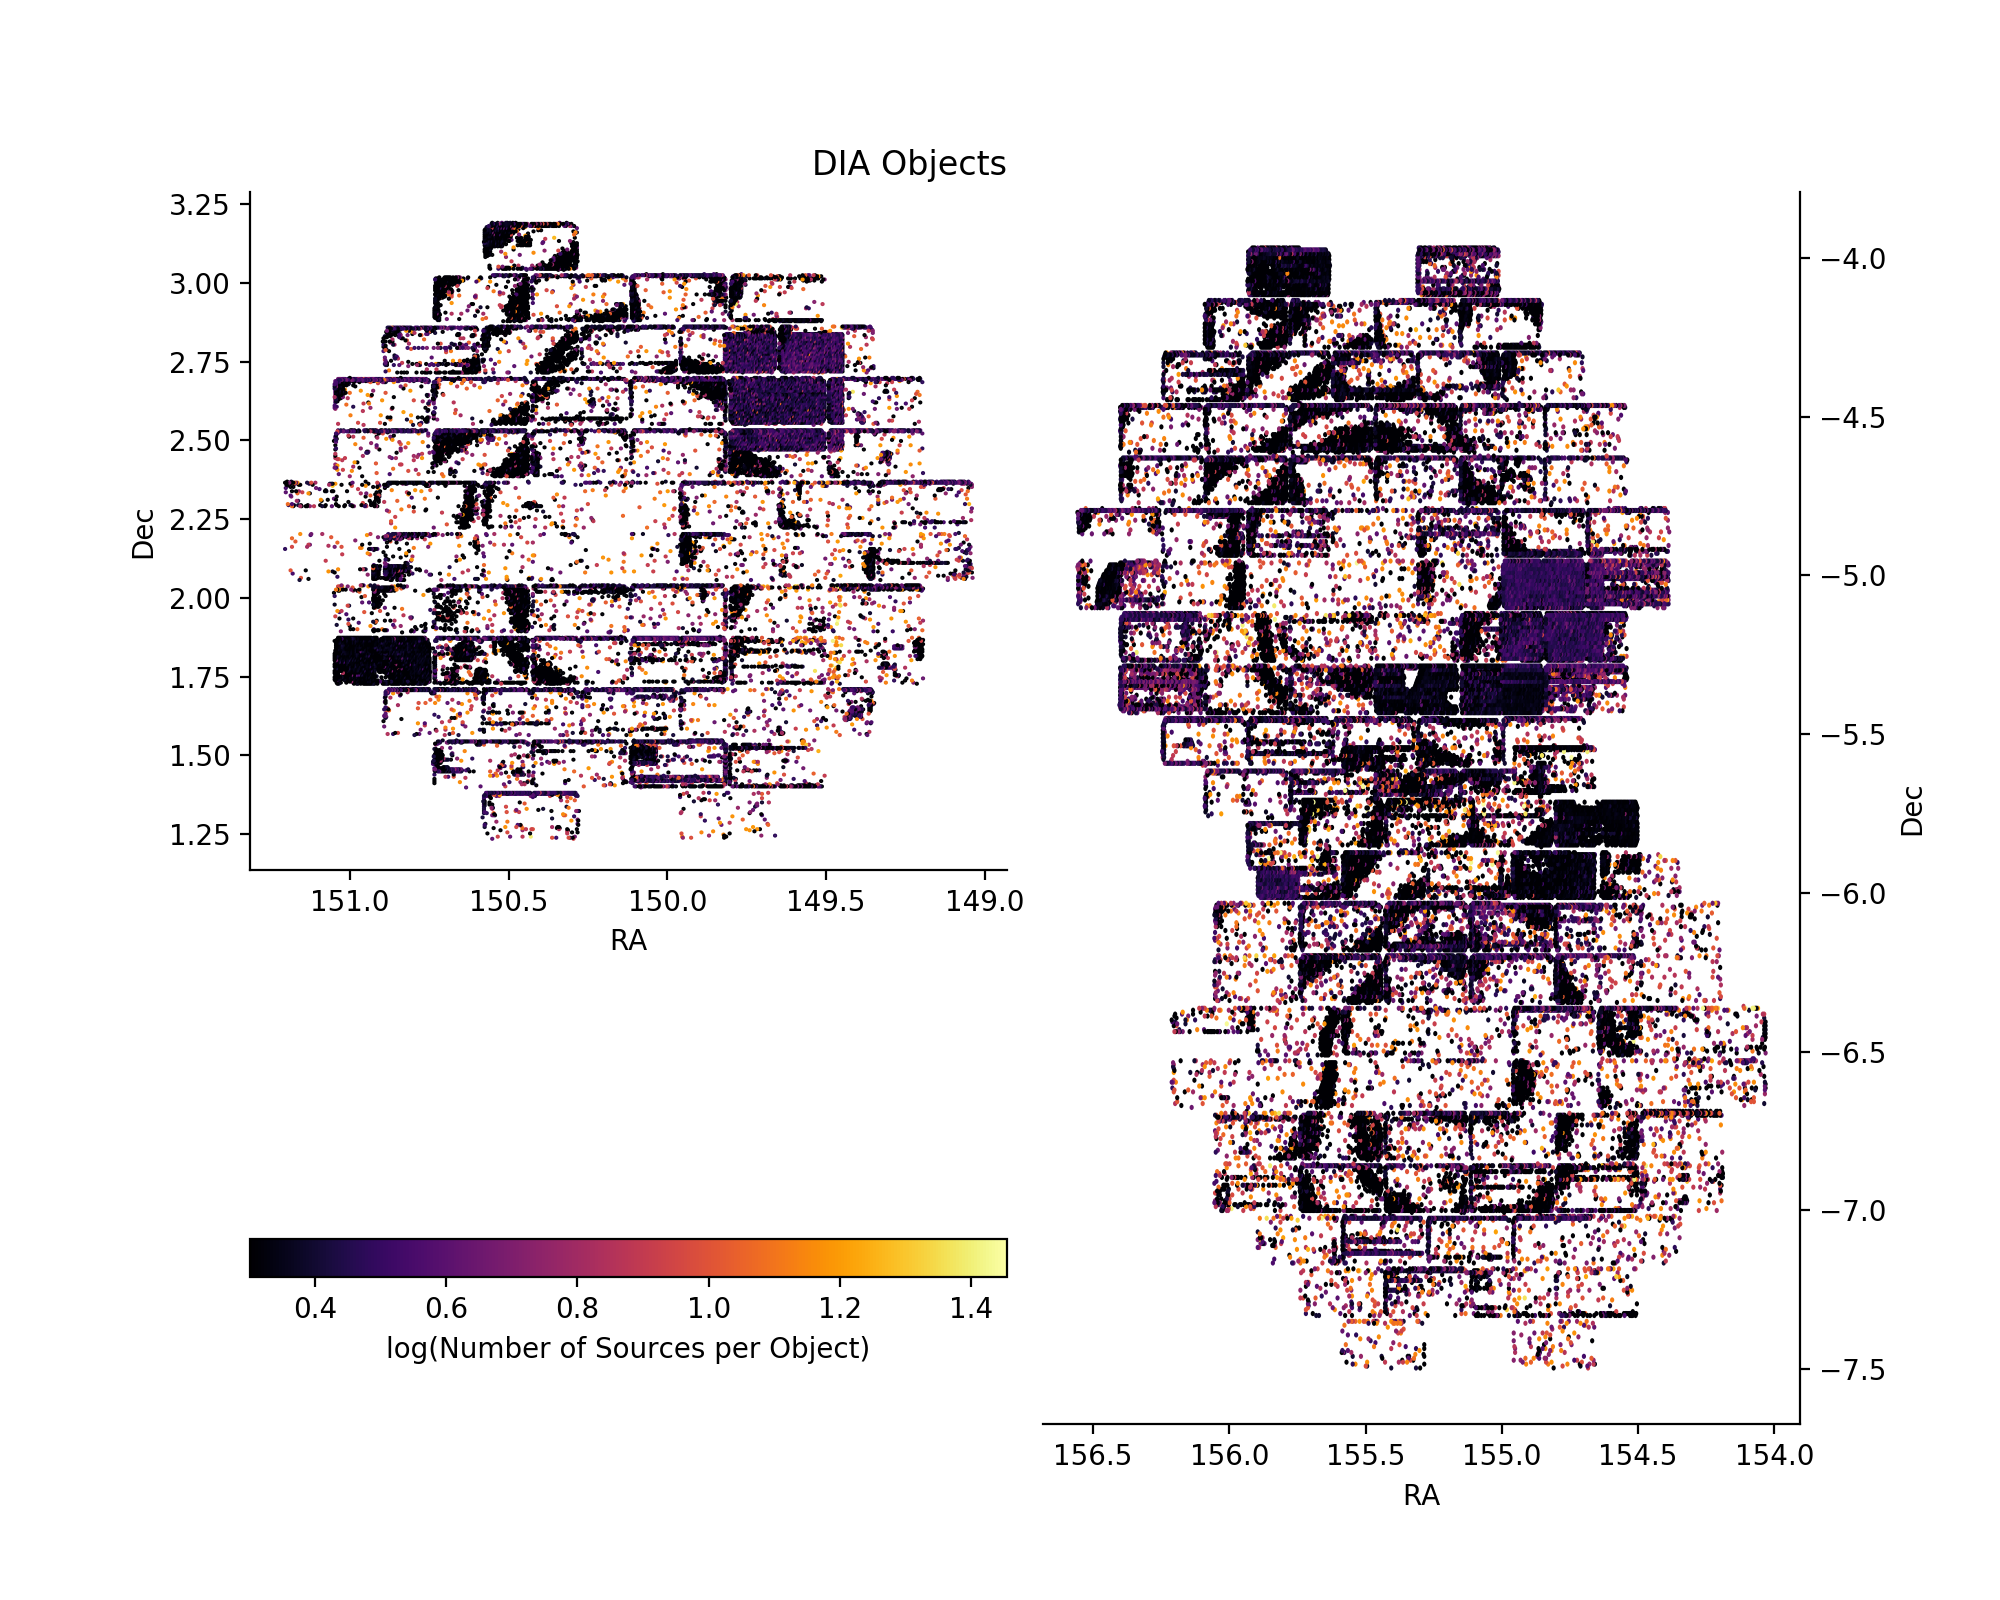

In [6]:
fig = plt.figure(facecolor='white', figsize=(10,8))
plt.subplots_adjust(wspace=0.1, hspace=0)

# Panel 1: one HiTS field
ax1 = plt.subplot2grid((4,4), (0,0), rowspan=4, colspan=2)
ax1.set_facecolor('white')
plot1 = plt.hexbin(objTable.loc[dec_set1, 'coord_ra'], objTable.loc[dec_set1, 'coord_dec'],
                   C=src_count1, cmap='inferno', bins='log', gridsize=500, mincnt=1)
plt.title('DIA Objects', loc='right')
plt.xlabel('RA')
plt.ylabel('Dec')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.invert_xaxis()  # RA should increase to the left
cb = fig.colorbar(plot1, orientation='horizontal', pad=0.3)
cb.set_label('log(Number of Sources per Object)')

# Panel 2: two (overlapping) HiTS fields
ax2 = plt.subplot2grid((4,4), (0,2), rowspan=4, colspan=2)
ax2.set_facecolor('white')
plot2 = plt.hexbin(objTable.loc[dec_set2, 'coord_ra'], objTable.loc[dec_set2, 'coord_dec'],
                   C=src_count2, cmap='inferno', bins='log', gridsize=500, mincnt=1)
plt.xlabel('RA')
plt.ylabel('Dec')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.invert_xaxis()

## Next plot goals
* Zoom in on the region in the vicinity of the CI dataset
* Plot all the visits as before, and now plot each source as a point (instead of hexbinnification)
* Size and color each object by number of sources

<IPython.core.display.Javascript object>


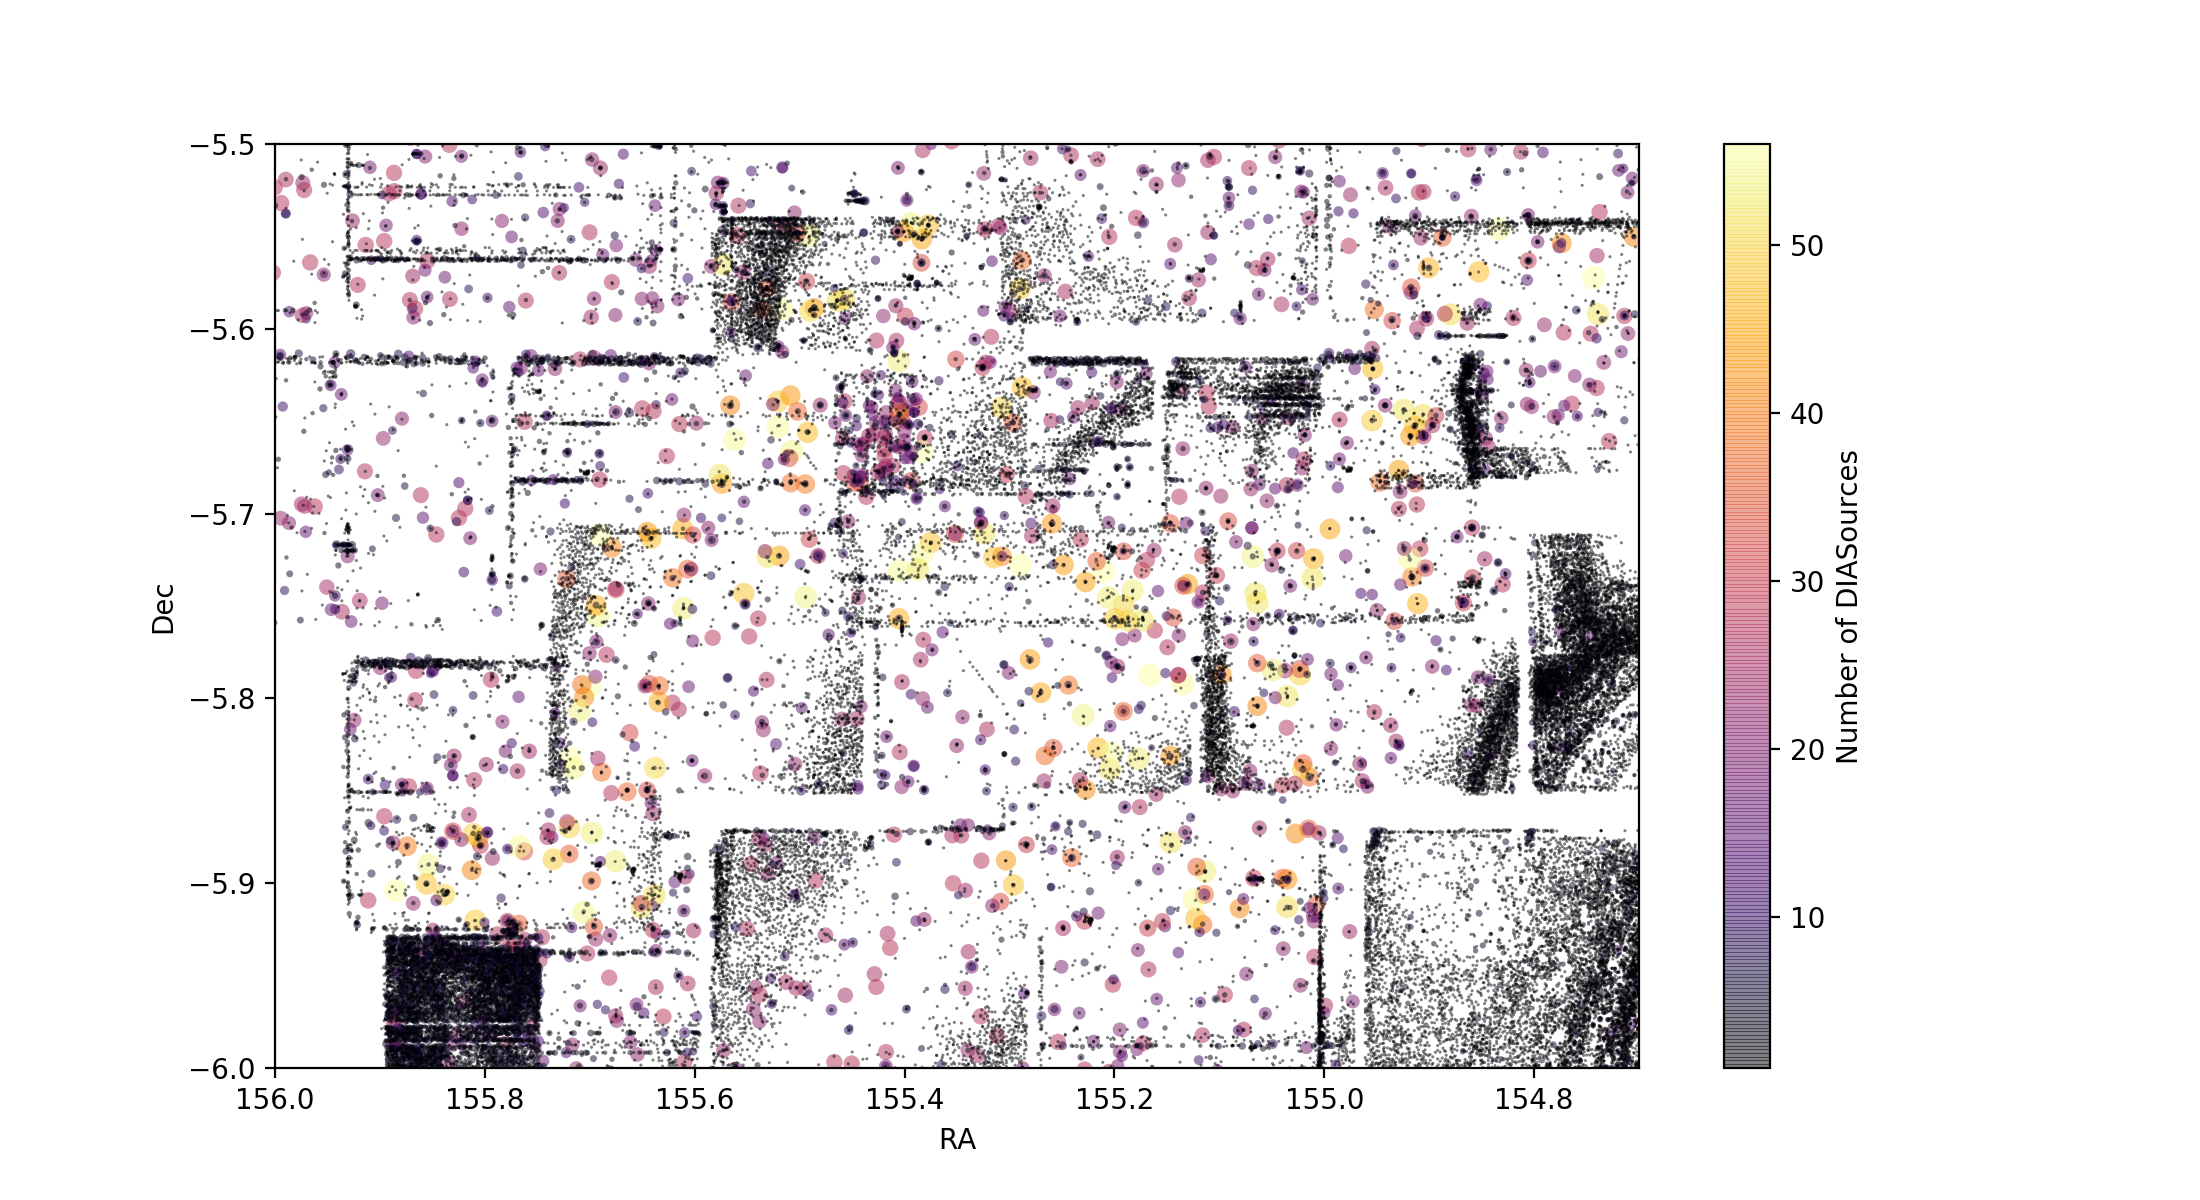

(-6.0, -5.5)

In [7]:
fig = plt.figure(facecolor='white', figsize=(11,6))
ax1 = fig.add_subplot(111)
cb1 = ax1.scatter(objTable.loc[dec_set2, 'coord_ra'], objTable.loc[dec_set2, 'coord_dec'], marker='.',
                  lw=0, s=src_count2*5, c=src_count2, alpha=0.5, cmap=plt.cm.get_cmap('inferno'))
cbplot = plt.colorbar(cb1, ax=ax1)
cbplot.set_label('Number of DIASources')

plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim([156, 154.7])
plt.ylim([-6.0, -5.5])
#plt.gca().invert_xaxis()

## Final plot goals

* Only plot certain CCDs and visits (the ones Krzysztof put in the CI dataset)

In [8]:
ci_visits = [41137156, 41137160, 41142005, 41142010, 41980205, 41980210]  # these ccdVisitIds only

In [9]:
objTable.set_index('id', inplace=True)  # ONLY DO THIS ONCE WHAT
objTable.index

Int64Index([176486661528486101, 176486661528486102, 176486661528486103,
            176486661528486104, 176486661528486105, 176486661528486106,
            176486661528486107, 176486661528486108, 176486661528486109,
            176486661528486110,
            ...
            181078664467710161, 181078664467710176, 181078664467710193,
            181078664467710197, 181078664467710202, 181078664467710209,
            181078664467710213, 181078664467710232, 181078664467710234,
            181078664467710237],
           dtype='int64', name='id', length=520448)

In [10]:
# get DIA Object IDs and DIA Source IDs corresponding to the list of ccdVisitIds
ci_objects = []
ci_sources = []
for ci_visit in ci_visits:
    ci_objects.extend(srcTable.loc[srcTable['ccdVisitId'] == ci_visit, 'diaObjectId'].values)
    ci_sources.extend(srcTable.loc[srcTable['ccdVisitId'] == ci_visit, 'id'].values)

print(len(ci_objects))
print(len(ci_sources))
# ci_objects is a list of DIA Object IDs from the srcTable
# because we made the 'id' column of objTable the new index, we can index by ci_objects directly!

1536
1536


In [11]:
srcTable.set_index('id', inplace=True)  # ONLY DO THIS ONCE TOO!!

In [12]:
all_src_count = objTable.loc[ci_objects, 'nDiaSources']

from collections import Counter
ci_src_count = list(Counter(ci_objects).values())

colors = []
for count in ci_src_count:
    if count == 1:
        colors.append('0.5')
    elif count == 2:
        colors.append('C0')
    elif count == 3:
        colors.append('C1')
    else:
        colors.append('C2')
        print(count)

## There will be two panels!
* Top: only the CCDs of interest, but still *all* the visits
* Bottom: only the CCDs of interests, and only 3 visits in the CI dataset

<IPython.core.display.Javascript object>


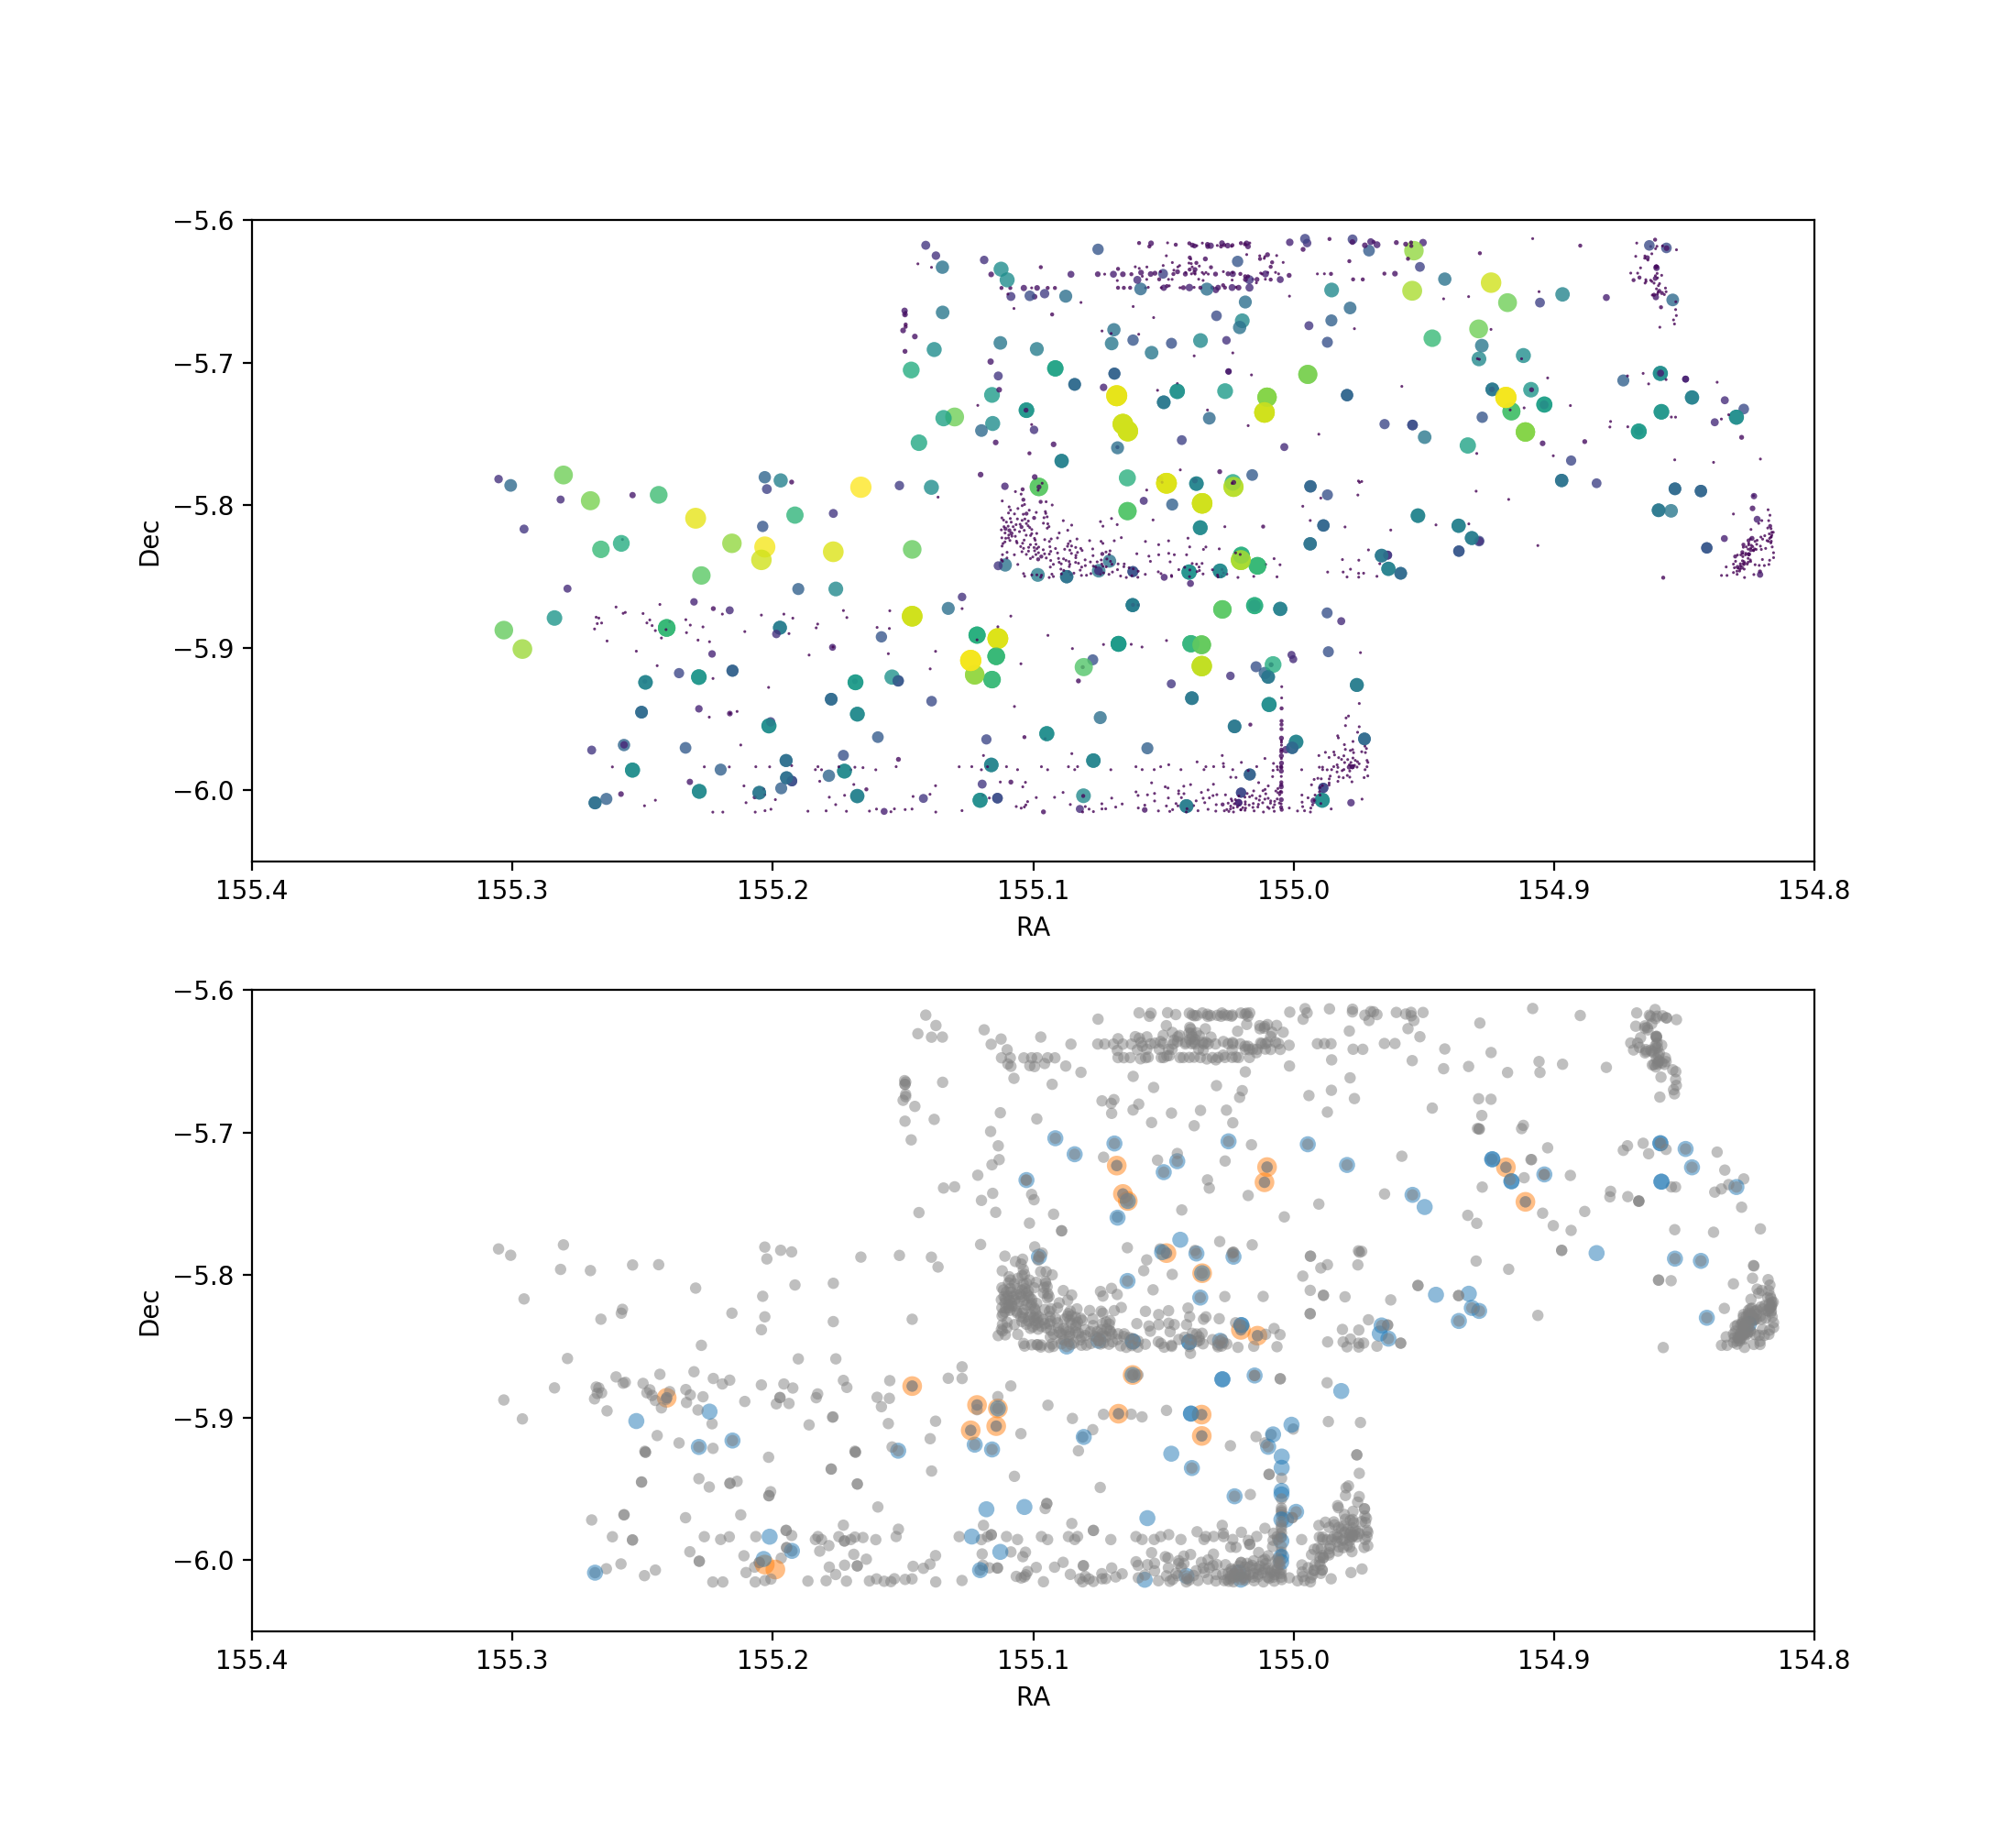

(-6.05, -5.6)

In [13]:
fig2 = plt.figure(facecolor='white', figsize=(11,10))
ax2 = fig2.add_subplot(211)

all_visits = ax2.scatter(objTable.loc[ci_objects, 'coord_ra'], objTable.loc[ci_objects, 'coord_dec'],
                         marker='.', lw=0, alpha=0.8, c=all_src_count, s=all_src_count*5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim([155.4, 154.8])
plt.ylim([-6.05, -5.6])

ax3 = fig2.add_subplot(212)
ci_visits = ax3.scatter(objTable.loc[ci_objects, 'coord_ra'].values, objTable.loc[ci_objects, 'coord_dec'].values,
                        marker='o', lw=0, alpha=0.5, s=[x*20 for x in ci_src_count], c=colors)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim([155.4, 154.8])
plt.ylim([-6.05, -5.6])
#plt.legend()

It appears that updating the CI dataset to include more fully overlapping chips solved the majority of the problem. The bottom plot above shows the sources detected on the sky with the three visits in this dataset. Small gray points are DIAObjects with a single DIASource, medium blue points are DIAObjects with two DIASources, and large orange points are DIAObjects with three DIASources.

It is clear from this plot that there are lots of single-source objects being detected near chip edges and corners. This is most likely due to artifacts in the difference imaging template. I suspect if this plot is recreated when DM-14762 is complete, many of the erroneous gray sources will disappear.